# Neural Network Classification with PyTorch

Classification is a problem of predicting whether something is one thing or another (there can be multiple things as the options)

## 1. Data Creation

In [ ]:
from sklearn.datasets import make_circles

#make 1000 samples
n_samples = 1000

X,y = make_circles(n_samples,
                   noise=0.03,
                   random_state=42)

In [ ]:
len(X),len(y)

(1000, 1000)

In [ ]:
print(f"First 5 samples of X : \n{X[:5]}")
print(f"First 5 samples of y : {y[:5]}")

First 5 samples of X : 
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y : [1 1 1 1 0]


In [ ]:
# make dataframe of circles
import pandas as pd

circles = pd.DataFrame({"X1":X[:,0],
                        "X2":X[:,1],
                        "label":y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


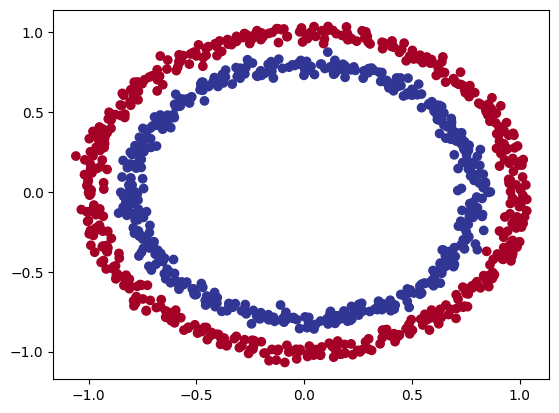

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

### 1.1 Check input and output shapes

In [ ]:
X.shape,y.shape

((1000, 2), (1000,))

### 1.2 Turn data into tensors and create train and test splits

In [ ]:
import torch
from torch import nn

In [ ]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X.shape,y.shape

(torch.Size([1000, 2]), torch.Size([1000]))

In [ ]:
#split data
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,
                                                 y,
                                                 test_size=0.2, #20% test and 80% train
                                                 random_state=42)

In [ ]:
len(X_train)

800

## 2. Building a model

Let's do the following:
1. Setup device agnostic code.
2. Construct a model (by subclassing nn.Module)
3. Define loss function and optimizer

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
#1. Construct a model
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    #2. Create 2 linear layers
    self.layer_1 = nn.Linear(in_features=2,
                             out_features=5)
    self.layer_2 = nn.Linear(in_features=5,
                             out_features=1)
  #3. Define the forward method
  def forward(self,x:torch.Tensor):
    return self.layer_2(self.layer_1(x))

In [ ]:
#4 Instantiate an instance of our model and send it to target device
model_0 = CircleModelV1().to(device)
model_0

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
next(model_0.parameters())

Parameter containing:
tensor([[ 0.5406,  0.5869],
        [-0.1657,  0.6496],
        [-0.1549,  0.1427],
        [-0.3443,  0.4153],
        [ 0.6233, -0.5188]], device='cuda:0', requires_grad=True)

In [ ]:
# Let's replicate above model using nn.Sequential()

model_0 = nn.Sequential(
    nn.Linear(in_features=2,out_features=5),
    nn.Linear(in_features=5,out_features=1)
).to(device)

In [ ]:
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
# Make Predictions
model_0.state_dict()

with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
untrained_preds[:10],y_test[:10]

(tensor([[-0.0338],
         [-0.0309],
         [ 0.0894],
         [-0.0692],
         [ 0.2967],
         [ 0.2968],
         [ 0.1405],
         [ 0.2178],
         [ 0.0805],
         [-0.0284]], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

### 2.1 Setup loss function and optimizer

For Regression:
* Loss function => MAE or MSE
* Optimizer => SGD or Adam

For Classification:
* Loss function => Cross Entropy or Binary Cross Entropy
* Optimizer => SGD or Adam

In [ ]:
loss_fn = nn.BCEWithLogitsLoss() # has sigmoid activation function built in
## BCELoss => requires that input to have gone through sigmoid activation
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [ ]:
# Calculate accuracy = out of a 100 examples, what percentage does our model get right???
def accuracy_fn(y_true,y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

## 3. Training our model

Steps in training loop:
1. Forward pass
2. Calculate loss
3. Optimizer zero grad
4. Loss Backward
5. Optimzer step

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**

We can convert these **logits** into prediction probabilities by passing them to some kind of activation function.(eq. sigmoid for Binary Classification and Softmax for Multiclass classification)

Then we convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the `argmax()`

In [ ]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]], device='cuda:0')

In [ ]:
# Use the sigmoid activation fn on our logits to get predicted probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]], device='cuda:0')

In [ ]:
# Find predicted labels
y_preds = torch.round(y_pred_probs)

y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device)[:5])))

### 3.2 Building training and testing loops

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train,y_train = X_train.to(device),y_train.to(device)
X_test,y_test = X_test.to(device),y_test.to(device)

for epoch in range(epochs):
  model_0.train()
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))
  loss = loss_fn(y_logits,y_train)  ## BCEWithLogitsLoss expects raw logits as input
  train_acc = accuracy_fn(y_train,y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits,y_test)
    test_acc = accuracy_fn(y_test,test_preds)

  if epoch%10==0:
    print(f"Epoch : {epoch} | Train Loss : {loss:.5f} | Train acc : {train_acc:.2f}% | Test Loss : {test_loss:.5f} | Test Acc : {test_acc:.2f}%")


Epoch : 0 | Train Loss : 0.69796 | Train acc : 51.88% | Test Loss : 0.69440 | Test Acc : 58.00%
Epoch : 10 | Train Loss : 0.69590 | Train acc : 51.25% | Test Loss : 0.69305 | Test Acc : 53.00%
Epoch : 20 | Train Loss : 0.69490 | Train acc : 51.62% | Test Loss : 0.69254 | Test Acc : 49.50%
Epoch : 30 | Train Loss : 0.69435 | Train acc : 51.12% | Test Loss : 0.69236 | Test Acc : 49.50%
Epoch : 40 | Train Loss : 0.69401 | Train acc : 50.88% | Test Loss : 0.69232 | Test Acc : 51.00%
Epoch : 50 | Train Loss : 0.69378 | Train acc : 50.25% | Test Loss : 0.69234 | Test Acc : 50.00%
Epoch : 60 | Train Loss : 0.69362 | Train acc : 50.00% | Test Loss : 0.69239 | Test Acc : 51.50%
Epoch : 70 | Train Loss : 0.69351 | Train acc : 50.25% | Test Loss : 0.69246 | Test Acc : 51.00%
Epoch : 80 | Train Loss : 0.69342 | Train acc : 49.88% | Test Loss : 0.69254 | Test Acc : 50.00%
Epoch : 90 | Train Loss : 0.69336 | Train acc : 49.88% | Test Loss : 0.69262 | Test Acc : 53.00%
Epoch : 100 | Train Loss : 0.69

## 4. Make predictions and evaluate

From the metrics it looks like our model isn't learning anything

So let's make some predictions and visualise it

We're goig to import a function called `plot_decision_boundary()`

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def plot_decision_boundary(model:torch.nn.Module,X:torch.Tensor,y:torch.Tensor):
  model.to("cpu")
  X,y = X.to("cpu"),y.to("cpu")

  x_max,x_min = X[:,0].max()+0.1,X[:,0].min()-0.1
  y_max,y_min = X[:,1].max()+0.1,X[:,1].min()-0.1

  xx,yy = np.meshgrid(np.linspace(x_min,x_max,101),np.linspace(y_min,y_max,101))

  X_for_preds = torch.from_numpy(np.column_stack((xx.ravel(),yy.ravel()))).float()

  model.eval()
  with torch.inference_mode():
    y_logits = model(X_for_preds)

  if(len(torch.unique(y))>2):
    y_preds = torch.softmax(y_logits,dim=1).argmax(dim=1)
  else:
    y_preds = torch.round(torch.sigmoid(y_logits))

  y_preds = y_preds.reshape(xx.shape).detach().numpy()
  plt.contourf(xx,yy,y_preds,cmap=plt.cm.RdYlBu,alpha=0.7)
  plt.scatter(X[:,0],X[:,1],c=y,s=40,cmap=plt.cm.RdYlBu)
  plt.xlim(xx.min(),xx.max())
  plt.ylim(yy.min(),yy.max())

def plot_predictions(train_data,train_labels,test_data,test_labels,predictions=None):
  plt.figure(figsize=(10,7))
  plt.scatter(train_data,train_labels,c="b",s=4,label="Training Data")
  plt.scatter(test_data,test_labels,c="r",s=4,label="Testing Data")
  if(predictions!=None):
    plt.scatter(test_data,test_labels,c="g",s=4,label="Prediction Data")
  plt.legend(prop={"size":14})

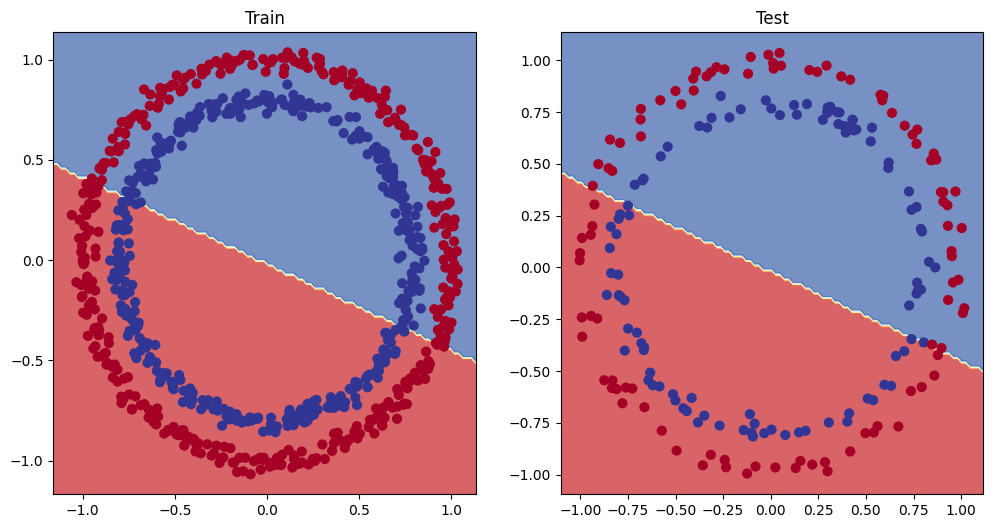

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0,X_test,y_test)

## 5. Improving a model (from a model perspective)

* Add more layers - give the model more chance to learn patterns in data
* Add more hidden units
* Fit for longer
* Changing the activation functions
* Change learning rate
* Change the loss function

Let's improve by:
1. Increasing hidden units -> from 5 to 10
2. Increase layers -> from 2 to 3
3. Increase epochs -> from 100 to 1000

In [ ]:
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,out_features=10)
    self.layer_2 = nn.Linear(in_features=10,out_features=10)
    self.layer_3 = nn.Linear(in_features=10,out_features=1)

  def forward(self,x:torch.Tensor):
    return self.layer_3(self.layer_2(self.layer_1(x)))

In [ ]:
model_2 = CircleModelV2().to(device)
model_2

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train,y_train = X_train.to(device),y_train.to(device)
X_test,y_test = X_test.to(device),y_test.to(device)

for epoch in range(epochs):
  model_2.train()

  y_logits = model_2(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))
  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_train,y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_2.eval()
  with torch.inference_mode():
    test_logits = model_2(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits,y_test)
    test_acc = accuracy_fn(y_test,test_pred)
  if epoch%100==0:
    print(f"Epoch : {epoch} | Train Loss : {loss:.5f} | Train acc : {train_acc:.2f}% | Test Loss : {test_loss:.5f} | Test Acc : {test_acc:.2f}%")

Epoch : 0 | Train Loss : 0.69528 | Train acc : 51.38% | Test Loss : 0.69252 | Test Acc : 50.50%
Epoch : 100 | Train Loss : 0.69325 | Train acc : 51.38% | Test Loss : 0.69283 | Test Acc : 51.00%
Epoch : 200 | Train Loss : 0.69309 | Train acc : 51.38% | Test Loss : 0.69344 | Test Acc : 46.50%
Epoch : 300 | Train Loss : 0.69303 | Train acc : 51.38% | Test Loss : 0.69384 | Test Acc : 47.50%
Epoch : 400 | Train Loss : 0.69300 | Train acc : 51.38% | Test Loss : 0.69412 | Test Acc : 46.50%
Epoch : 500 | Train Loss : 0.69299 | Train acc : 51.38% | Test Loss : 0.69431 | Test Acc : 46.00%
Epoch : 600 | Train Loss : 0.69298 | Train acc : 51.38% | Test Loss : 0.69444 | Test Acc : 46.00%
Epoch : 700 | Train Loss : 0.69298 | Train acc : 51.38% | Test Loss : 0.69452 | Test Acc : 45.50%
Epoch : 800 | Train Loss : 0.69298 | Train acc : 51.38% | Test Loss : 0.69458 | Test Acc : 44.50%
Epoch : 900 | Train Loss : 0.69298 | Train acc : 51.38% | Test Loss : 0.69461 | Test Acc : 45.00%


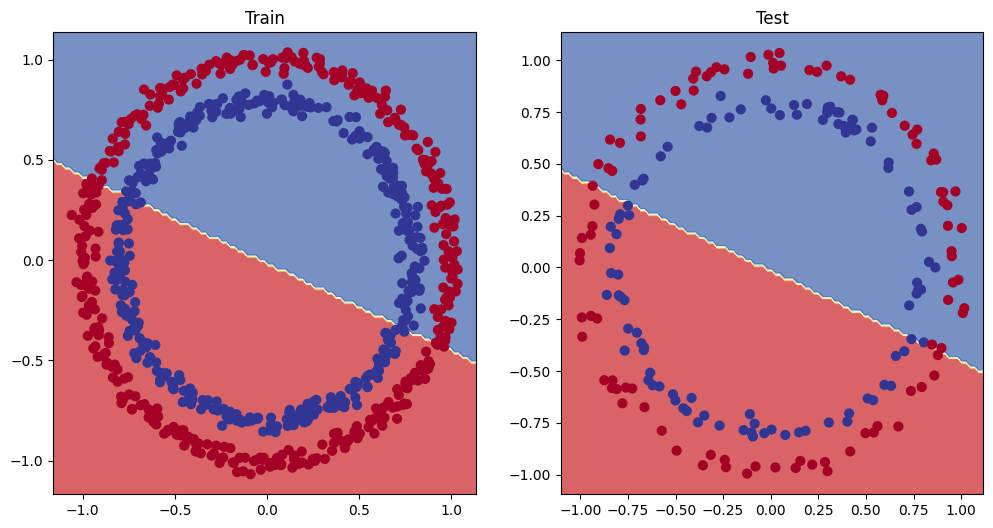

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_2,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_2,X_test,y_test)

### 5.1 Preparing data to see if our model can fir straight line

One way to troubleshoot to a larger problem is to test out a smaller problem

In [ ]:
# Create some data
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.01

X_regression = torch.arange(start,end,step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

NameError: ignored

In [ ]:
train_split = int(0.8*len(X_regression))

## 6. Non Linearity

### 6.1 Recreating the data

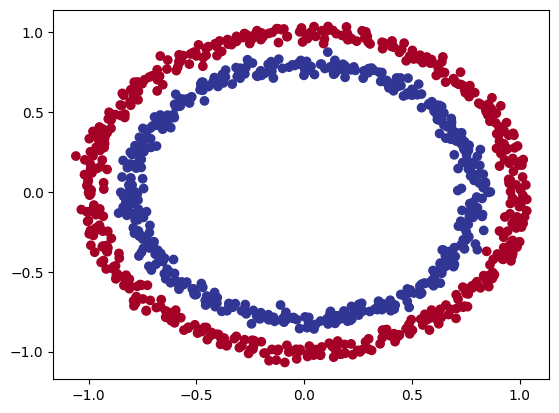

In [ ]:
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt

n_samples = 1000

X,y = make_circles(n_samples,
                   noise=0.03,
                   random_state=42)
plt.scatter(X[:,0],X[:,1],c=y,cmap=plt.cm.RdYlBu)

In [ ]:
# Convert data to tensors and split to train and test
from sklearn.model_selection import train_test_split
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train,X_test,y_train,y_test = train_test_split(X,
                                                 y,
                                                 test_size=0.2,
                                                 random_state=42)
X_train[:5],y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non linearity

In [ ]:
from torch import nn
class CircleModelV3(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features=2,out_features=10)
    self.layer_2 = nn.Linear(in_features=10,out_features=15)
    self.layer_3 = nn.Linear(in_features=15,out_features=10)
    self.layer_4 = nn.Linear(in_features=10,out_features=1)
    self.relu = nn.ReLU()

  def forward(self,x:torch.Tensor):
    return self.layer_4(self.relu(self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))))

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_3 = CircleModelV3().to(device)
model_3

CircleModelV3(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=15, bias=True)
  (layer_3): Linear(in_features=15, out_features=10, bias=True)
  (layer_4): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
next(model_3.parameters()).device

device(type='cuda', index=0)

### 6.3 Training the model

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr=0.1)
def accuracy_fn(true_data,pred_data):
  correct_value = torch.eq(true_data,pred_data).sum().item()
  return (correct_value/len(true_data))*100

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train,y_train = X_train.to(device),y_train.to(device)
X_test,y_test = X_test.to(device),y_test.to(device)

epochs = 2000

for epoch in range(epochs):
  model_3.train()

  y_logits = model_3(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_train,y_preds)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits,y_test)
    test_acc = accuracy_fn(y_test,test_preds)

  if epoch%100==0:
    print(f"Epoch : {epoch} | Loss : {loss:.5f} | Acc : {acc:.2f} | Test Loss : {test_loss:.5f} | Test acc : {test_acc:.2f}")

Epoch : 0 | Loss : 0.69444 | Acc : 50.00 | Test Loss : 0.69417 | Test acc : 50.00
Epoch : 100 | Loss : 0.69276 | Acc : 61.25 | Test Loss : 0.69263 | Test acc : 64.00
Epoch : 200 | Loss : 0.69229 | Acc : 53.75 | Test Loss : 0.69217 | Test acc : 57.00
Epoch : 300 | Loss : 0.69174 | Acc : 56.00 | Test Loss : 0.69162 | Test acc : 55.50
Epoch : 400 | Loss : 0.69102 | Acc : 55.62 | Test Loss : 0.69088 | Test acc : 55.00
Epoch : 500 | Loss : 0.68988 | Acc : 56.38 | Test Loss : 0.68969 | Test acc : 55.50
Epoch : 600 | Loss : 0.68818 | Acc : 55.75 | Test Loss : 0.68793 | Test acc : 55.00
Epoch : 700 | Loss : 0.68564 | Acc : 55.75 | Test Loss : 0.68520 | Test acc : 55.00
Epoch : 800 | Loss : 0.68165 | Acc : 55.88 | Test Loss : 0.68078 | Test acc : 55.00
Epoch : 900 | Loss : 0.67513 | Acc : 57.38 | Test Loss : 0.67350 | Test acc : 56.00
Epoch : 1000 | Loss : 0.66400 | Acc : 60.75 | Test Loss : 0.66166 | Test acc : 62.00
Epoch : 1100 | Loss : 0.64429 | Acc : 66.75 | Test Loss : 0.64135 | Test acc 

### 6.4 Visualise

In [ ]:
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:5],y_test[:5]

(tensor([1., 0., 1., 0., 1.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1.], device='cuda:0'))

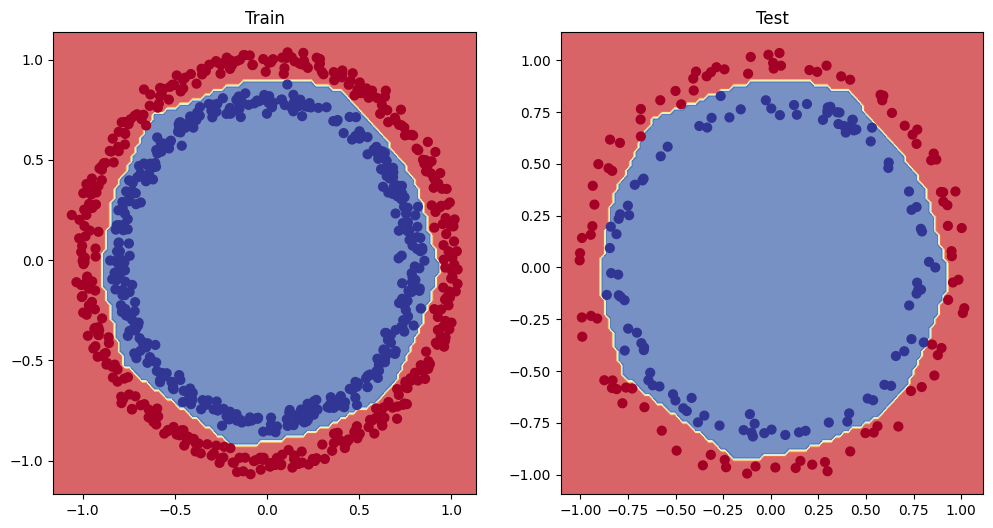

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3,X_test,y_test)

## 7. Replicating a non-linear activation function

Rather than us telling the model what to learn, we give it the tools to discover patterns in data and it tries to figure out the best patterns on its own

These tools are linear and non-linear functions

In [ ]:
#Create a tensor

A = torch.arange(-10,10,1,dtype=torch.float)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

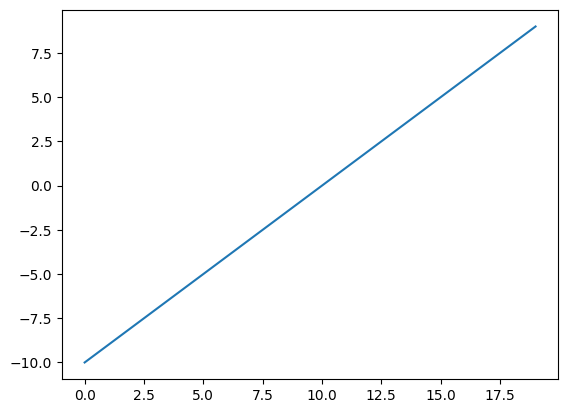

In [ ]:
#Visualise the tensor

plt.plot(A)

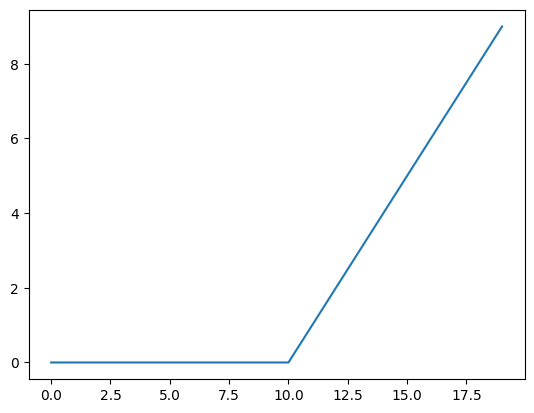

In [ ]:
plt.plot(torch.relu(A))

In [ ]:
def relu(x:torch.Tensor):
  return torch.maximum(torch.tensor(0),x)

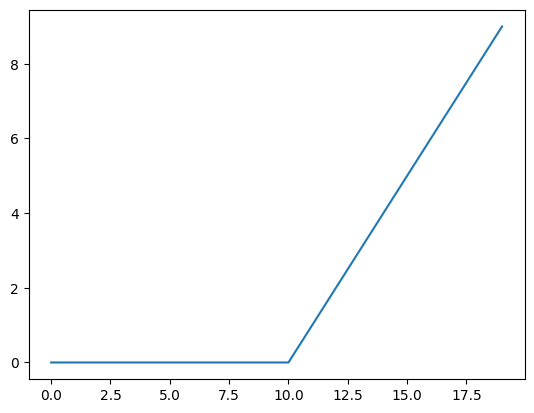

In [ ]:
plt.plot(relu(A))

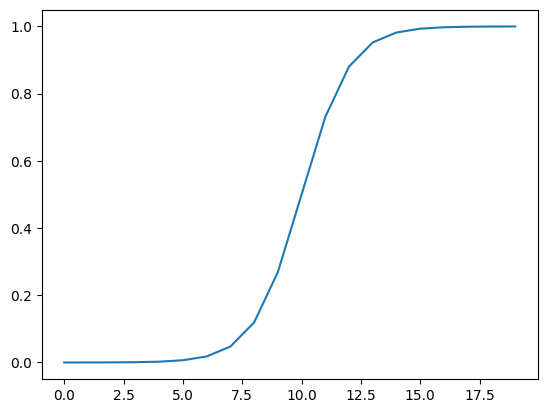

In [ ]:
plt.plot(torch.sigmoid(A))

In [ ]:
def sigmoid(x:torch.Tensor):
  return 1/(1+torch.exp(-x))

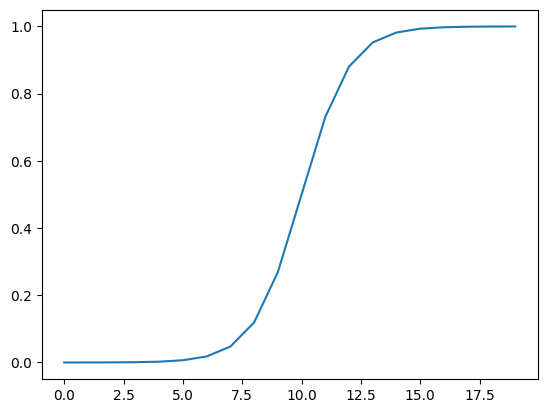

In [ ]:
plt.plot(sigmoid(A))